In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import FortranFile
from cobaya.model import get_model
import yaml
import os
from getdist import plots, MCSamples
from cobaya.conventions import Const, packages_path_input


In [2]:
path_GLM_data = os.path.realpath(os.path.join(os.getcwd(), 'GLM_data/'))

In [3]:
path_GLM_data

'/home/afarina/ParametricModels/LCDM/GLM_data'

In [4]:
getdist_settings = {
    'smooth_scale_1D': 0.3,
    'smooth_scale_2D': 0.4,
    'boundary_correction_order': 1,
    'mult_bias_correction_order': 1,
    }

## ACT

In [5]:
yaml_path = os.path.realpath(os.path.join(os.getcwd(), 'chains/01p3_LCDM_CMB_ACTTTTEEE.input.yaml'))

In [6]:
# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')

# build the model:
model = get_model(params_dict)

Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
[camb] `camb` module loaded successfully from /home/afarina/anaconda3/envs/nbase/lib/python3.12/site-packages/camb


In [7]:
ACT_datavector = model.components[0].data_vec

np.save('GLM_data/ACT_datavector', ACT_datavector)

In [8]:
ACT_covmat = model.components[0].covmat

np.save('GLM_data/cov_data_ACT', ACT_covmat)

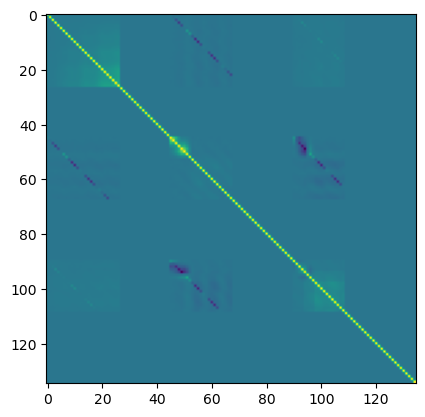

In [9]:
ACT_corr = ACT_covmat / np.outer( np.sqrt(np.diag(ACT_covmat)), np.sqrt(np.diag(ACT_covmat)))

plt.imshow(ACT_corr)

In [10]:
chains_dir = os.path.join('chains')

# import chain
from cobaya import load_samples

name = '01p3_LCDM_CMB_ACTTTTEEE'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))

[samplecollection] Loaded 3906 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.1.txt'


[samplecollection] Loaded 4377 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.2.txt'
[samplecollection] Loaded 4388 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.3.txt'
[samplecollection] Loaded 4003 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.4.txt'
01p3_LCDM_CMB_ACTTTTEEE: R = 0.0113


In [11]:
params = model.parameterization.sampled_params()
print(params)

{'H0': nan, 'logA': nan, 'ns': nan, 'ombh2': nan, 'omch2': nan, 'tau': nan, 'A_act': nan, 'P_act': nan}


In [12]:
BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()

In [13]:
for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters

In [14]:
model.provider.set_current_input_params(params)
logposterior = model.loglike(params, return_derived=False)
Cls = model.provider.get_Cl(ell_factor=True)

In [15]:
Cls

{'ell': array([    0,     1,     2, ..., 10451, 10452, 10453]),
 'tt': array([0.00000000e+00, 0.00000000e+00, 1.07420923e+03, ...,
        1.17596796e-01, 1.17738309e-01, 1.17881813e-01]),
 'ee': array([0.        , 0.        , 0.04148078, ..., 0.00142582, 0.00142545,
        0.00142509]),
 'bb': array([0.00000000e+00, 0.00000000e+00, 1.97610555e-06, ...,
        1.09088333e-03, 1.09064410e-03, 1.09040500e-03]),
 'te': array([ 0.00000000e+00,  0.00000000e+00,  3.18886868e+00, ...,
        -1.95572631e-03, -1.95437136e-03, -1.95301324e-03]),
 'et': array([ 0.00000000e+00,  0.00000000e+00,  3.18886868e+00, ...,
        -1.95572631e-03, -1.95437136e-03, -1.95301324e-03])}

In [16]:
model.components[0].__dict__

{'delay': 0,
 '_measured_speed': None,
 '_name': 'act_dr6_cmbonly.ACTDR6CMBonly',
 'packages_path': '/home/afarina/cobaya_likelihoods',
 'url': 'https://lambda.gsfc.nasa.gov/data/act/pspipe/sacc_files/',
 'input_file': 'dr6_data_cmbonly.fits',
 'data_folder': '/home/afarina/cobaya_likelihoods/data/ACTDR6CMBonly',
 'version': 'v1.0',
 'ell_cuts': {'TT': [600, 1945], 'TE': [600, 1710], 'EE': [600, 1534]},
 'lmax_theory': 8502,
 'params': {'A_act': {'prior': {'dist': 'norm', 'loc': 1, 'scale': 0.0025},
   'ref': {'dist': 'norm', 'loc': 1, 'scale': 0.002},
   'proposal': 0.0005,
   'latex': 'A_{\\rm ACT}'},
  'P_act': {'prior': {'min': 0.9, 'max': 1.1},
   'ref': {'dist': 'norm', 'loc': 1.0, 'scale': 0.01},
   'proposal': 0.01,
   'latex': 'p_{\\rm ACT}'}},
 'type': [],
 'speed': -1,
 'stop_at_error': False,
 'log': <Logger act_dr6_cmbonly.actdr6cmbonly (INFO)>,
 'timer': None,
 'spec_meta': [{'data_type': 'cl_00',
   'tracer1': 'dr6_cmb_s0',
   'tracer2': 'dr6_cmb_s0',
   'pol': 'tt',
   

In [17]:
model.components[0].spec_meta[0]

{'data_type': 'cl_00',
 'tracer1': 'dr6_cmb_s0',
 'tracer2': 'dr6_cmb_s0',
 'pol': 'tt',
 'ell': array([ 600.5,  650.5,  700.5,  750.5,  800.5,  850.5,  900.5,  950.5,
        1000.5, 1050.5, 1100.5, 1150.5, 1200.5, 1250.5, 1300.5, 1350.5,
        1400.5, 1450.5, 1500.5, 1550.5, 1600.5, 1650.5, 1700.5, 1750.5,
        1800.5, 1850.5, 1900.5]),
 'spec': array([2305.01430449, 1858.80403605, 1903.12868071, 2295.14571215,
        2506.73749559, 2404.12526051, 1897.40086325, 1350.36317638,
        1079.60548439, 1090.7935929 , 1217.44842389, 1204.34744404,
        1043.30953061,  846.31723476,  727.3198088 ,  751.70762636,
         801.31071604,  793.9967811 ,  695.0413958 ,  533.17964415,
         426.04962016,  390.22641636,  392.27002153,  388.32104263,
         356.57807162,  294.14227543,  257.94965117]),
 'idx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 'window': <sacc.windows.BandpowerWindow at 0x7f9f

In [18]:
lmin, lmax = 600, 6500

ls = Cls['ell']

mask_ls = (ls >= lmin) & (ls <= lmax)

In [19]:
ps_vec = np.zeros_like(ACT_datavector)

for m in model.components[0].spec_meta:
    idx = m["idx"]
    win = m["window"].weight.T
    ls = m["window"].values
    pol = m["pol"]
    dat = Cls[pol][ls] / (params['A_act'] * params['A_act'])
    if pol[0] == "e":
        dat /= params['P_act']
    if pol[1] == "e":
        dat /= params['P_act']

    ps_vec[idx] = win @ dat

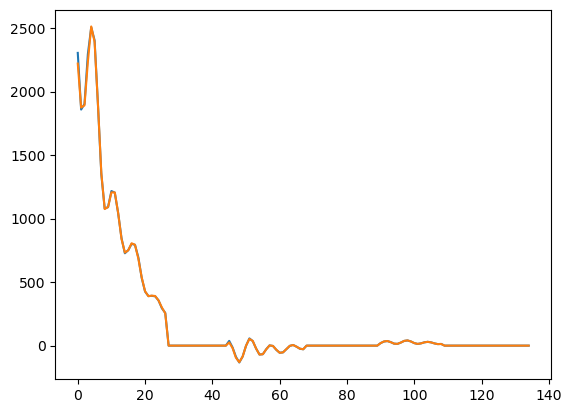

In [20]:
plt.plot(ACT_datavector)
plt.plot(ps_vec)

In [21]:
len(ps_vec), len(ACT_datavector)

(135, 135)

## Planck High-L

In [22]:
yaml_path = os.path.realpath(os.path.join(os.getcwd(), 'chains/01p2_LCDM_CMB_PlanckTTTEEE.minimize.input.yaml'))

# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')
# build the model:
model = get_model(params_dict)

Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.
[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'minimize']
[camb] `camb` module loaded successfully from /home/afarina/anaconda3/envs/nbase/lib/python3.12/site-packages/camb


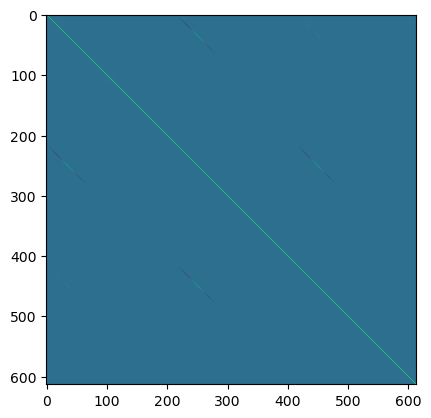

In [23]:
Planck_hl_cov = model.components[0].cov
Planck_hl_corr = Planck_hl_cov / np.outer( np.sqrt(np.diag(Planck_hl_cov)),  np.sqrt(np.diag(Planck_hl_cov)))

plt.imshow(Planck_hl_corr)

In [25]:
np.save(path_GLM_data + "/cov_Planck_hl", Planck_hl_cov)

In [26]:
chains_dir = os.path.join('chains')

# import chain
from cobaya import load_samples

name = '01p2_LCDM_CMB_PlanckTTTEEE'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))

[samplecollection] Loaded 4123 sample points from 'chains/01p2_LCDM_CMB_PlanckTTTEEE.1.txt'
[samplecollection] Loaded 4281 sample points from 'chains/01p2_LCDM_CMB_PlanckTTTEEE.2.txt'


[samplecollection] Loaded 4116 sample points from 'chains/01p2_LCDM_CMB_PlanckTTTEEE.3.txt'
[samplecollection] Loaded 4117 sample points from 'chains/01p2_LCDM_CMB_PlanckTTTEEE.4.txt'
01p2_LCDM_CMB_PlanckTTTEEE: R = 0.0079


In [27]:
params = model.parameterization.sampled_params()
print(params)

BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()


for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters


model.provider.set_current_input_params(params)
logposterior = model.loglike(params, return_derived=False)
Cls = model.provider.get_Cl(ell_factor=True)

{'H0': nan, 'logA': nan, 'ns': nan, 'ombh2': nan, 'omch2': nan, 'tau': nan, 'A_planck': nan}


In [28]:
model.components[0].__dict__

{'delay': 0,
 '_measured_speed': None,
 '_name': 'act_dr6_cmbonly.PlanckActCut',
 'packages_path': '/home/afarina/cobaya_likelihoods',
 'path': '/home/afarina/cobaya_likelihoods/data/planck_2018_pliklite_native',
 'dataset_file': 'plik_lite_v22.dataset',
 'dataset_params': {'use_cl': 'tt te ee',
  'lmin_cuts': '0 0 0',
  'lmax_cuts': '1000 600 600'},
 'aliases': ['plikHM_TTTEEE'],
 'speed': 200,
 'params': {'A_planck': {'prior': {'dist': 'norm', 'loc': 1, 'scale': 0.0025},
   'ref': {'dist': 'norm', 'loc': 1, 'scale': 0.002},
   'proposal': 0.0005,
   'latex': 'y_\\mathrm{cal}',
   'renames': 'calPlanck'}},
 'type': 'CMB',
 'stop_at_error': False,
 'version': None,
 'input_params': ['A_planck'],
 'output_params': [],
 'log': <Logger act_dr6_cmbonly.planckactcut (INFO)>,
 'timer': None,
 'dataset_filename': '/home/afarina/cobaya_likelihoods/data/planck_2018_pliklite_native/plik_lite_v22.dataset',
 'use_cl': ['tt', 'te', 'ee'],
 'calibration_param': 'A_planck',
 'blmin': array([  30,   3

In [29]:
blmax = model.components[0].blmax
blmin = model.components[0].blmin

used_bins = model.components[0].used_bins
weights = model.components[0].weights

used_indices = model.components[0].used_indices


In [30]:
def binning_matrix(ix=0):
    # not used by main likelihood code
    lmax = blmax[used_bins[ix][-1]]
    lmin = blmin[used_bins[ix][0]]
    m = np.zeros((len(used_bins[ix]), lmax - lmin + 1))
    for i in used_bins[ix]:
        m[i, blmin[i] - lmin:blmax[i] + 1 - lmin] = weights[
                                                                blmin[i]:
                                                                blmax[i] + 1]
    return lmin, lmax, m

In [31]:
L0 = Cls['ell'][0]

cl = np.empty(used_indices.shape)
ix = 0
for tp, cell in enumerate([Cls['tt'], Cls['te'], Cls['ee']]):
    for i in used_bins[tp]:
        cl[ix] = np.dot(cell[blmin[i] - L0:blmax[i] - L0 + 1],
                        weights[blmin[i]:blmax[i] + 1])
        ix += 1
cl /= params['A_planck'] ** 2

In [33]:
Planck_datavector = model.components[0].X_data

np.save(path_GLM_data + '/Planck_hl_datavector', Planck_datavector)

In [ ]:
plt.loglog(Planck_datavector)
plt.loglog(cl)

# BAO

In [ ]:
yaml_path = os.path.realpath(os.path.join(os.getcwd(), 'chains/01p1_LCDM_BAO_DESIDR2.input.yaml'))

# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')
# build the model:
model = get_model(params_dict)

In [ ]:
model.provider?

In [ ]:
cov = model.components[0].cov
corr = cov / np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)))
plt.imshow(corr)

In [ ]:
np.save(path_GLM_data + "cov_data_BAO.npy", cov)

In [ ]:
redshifts = np.array(model.components[0].data['z'])
BAO_datavector = np.array(model.components[0].data['value'])
observables = np.array(model.components[0].data['observable']).astype(str)

In [ ]:
chains_dir = os.path.join('chains')

# import chain
from cobaya import load_samples

name = '01p1_LCDM_BAO_DESIDR2'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))

In [ ]:
params = model.parameterization.sampled_params()
print(params)

BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()


for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters


model.provider.set_current_input_params(params)
logposterior = model.loglike(params, return_derived=False)

rdrag = model.components[0].provider.get_param("rdrag")
rs = rdrag * model.components[0].rs_rescale

In [ ]:
def theory_fun(z, observable):
    # Functions to get the corresponding theoretical prediction:
    # Spherically-averaged distance, over sound horizon radius
    if observable == "DV_over_rs":
        return np.cbrt(
            ((1 + z) * model.provider.get_angular_diameter_distance(z)) ** 2 *
            Const.c_km_s * z / model.provider.get_Hubble(z,
                                                        units="km/s/Mpc")) / rs
    # Idem, inverse
    elif observable == "rs_over_DV":
        return np.cbrt(
            ((1 + z) * model.provider.get_angular_diameter_distance(z)) ** 2 *
            Const.c_km_s * z / model.provider.get_Hubble(z, units="km/s/Mpc")
        ) ** (-1) * rs
    # Comoving angular diameter distance, over sound horizon radius
    elif observable == "DM_over_rs":
        return (1 + z) * model.provider.get_angular_diameter_distance(z) / rs
    # Physical angular diameter distance, over sound horizon radius
    elif observable == "DA_over_rs":
        return model.provider.get_angular_diameter_distance(z) / rs
    # Hubble distance [c/H(z)] over sound horizon radius.
    elif observable == "DH_over_rs":
        return 1 / model.provider.get_Hubble(z, units="1/Mpc") / rs
    # Hubble parameter, times sound horizon radius
    elif observable == "Hz_rs":
        return model.provider.get_Hubble(z, units="km/s/Mpc") * rs
    # Diff Linear Growth Rate times present amplitude
    elif observable == "f_sigma8":
        return model.provider.get_fsigma8(z)
    # Anisotropy (Alcock-Paczynski) parameter
    elif observable == "F_AP":
        return ((1 + z) * model.provider.get_angular_diameter_distance(z) *
                model.provider.get_Hubble(z, units="km/s/Mpc")) / Const.c_km_s

In [ ]:
BAO_model = np.array([theory_fun(redshifts[i], observables[i]) for i in range(len(redshifts))]).flatten()

In [ ]:
plt.plot(BAO_model)
plt.plot(BAO_datavector)

# DES Supernovae

In [ ]:
yaml_path = os.path.realpath(os.path.join(os.getcwd(), 'chains/01p5_LCDM_SN_DESY5.input.yaml'))

# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')
# build the model:
model = get_model(params_dict)

In [ ]:
cov = model.components[0].covs['mag']
corr = cov / np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)))
plt.imshow(corr)

In [ ]:
cols = model.components[0].cols

mag = model.components[0].mag 
invcov = model.components[0].invcov

zcmb = model.components[0].zcmb
zhel = model.components[0].zhel

In [ ]:
chains_dir = os.path.join('chains')

# import chain
from cobaya import load_samples

name = '01p5_LCDM_SN_DESY5'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))

In [ ]:
params = model.parameterization.sampled_params()
print(params)

BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()


for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters


model.provider.set_current_input_params(params)
logposterior = model.loglike(params, return_derived=False)


In [ ]:
angular_diameter_distances = model.provider.get_angular_diameter_distance(zcmb)
SN_model = 5 * np.log10((1 + zhel) * (1 + zcmb) * angular_diameter_distances) 


In [ ]:
plt.plot(SN_model + 25, label='model')
plt.plot(mag, label='data')
plt.title('DESY5 Supernovae')
plt.xlabel("SN #")
plt.ylabel("Mag")
plt.legend()

In [ ]:
model.components[0].__dict__

In [ ]:
model.components[0].__dict__